In [1]:
# importando as libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import os
import keras
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


2022-11-30 17:51:13.270810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 17:51:13.385017: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-30 17:51:13.797140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-30 17:51:13.797188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
class TFBasicAutoencoder(Model):
  def __init__(self, latent_dim,input_size):
    super(TFBasicAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(input_size, activation='sigmoid'),      
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

from keras import regularizers


class TFSparsityConstraintAutoencoder(Model):
  
  def __init__(self, latent_dim):
    super(TFSparsityConstraintAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([ 
      layers.Dense(latent_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5)),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),      
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


class DeepAutoencoder(Model):
  
  def __init__(self, latent_dim):
    super(DeepAutoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([ 
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(784, activation='sigmoid'),      
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded















In [3]:
class ConvolutionalAutoencoderv1(Model):
  
  def __init__(self, latent_dim):
    super(ConvolutionalAutoencoderv1, self).__init__()
    self.latent_dim = latent_dim     
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

   


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [4]:
def normalize_image(x_train,x_test):
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    return x_train,x_test

def data_reshape(x_train,x_test):
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    return x_train,x_test




In [5]:

def plot_images(data_decoded,original_data):
    n = 10
    rows=len(data_decoded)+1
    plt.figure(figsize=(20, rows*3))
    for i in range(n):
      # display original
      ax = plt.subplot(rows, n, i + 1)
      plt.imshow(original_data[i].reshape(28, 28))
      plt.title("original")
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
    t=1
    for decoded_imgs in data_decoded:
         for i in range(n):
              #print(i + 1+t + n)              
              # display reconstruction
              ax = plt.subplot(rows, n, i+1 +n*t)
              plt.imshow(decoded_imgs[i].reshape(28, 28))
              
              plt.title(" latent_dim "+str(reducers[t-1][1]["latent_dim"]))
              plt.gray()
              ax.get_xaxis().set_visible(False)
              ax.get_yaxis().set_visible(False)
         t=t+1
    plt.show()
    
def plot_umap(data,labels):  
    import umap
    plt.figure(figsize=(25, 10))
    rows=2    
    col=int(len(data_decoded)/2 +len(data_decoded) % 2)
    dim_reducer = umap.UMAP(n_components=2)
    
    
    """latent_space_reduced = dim_reducer.fit_transform(data)  
    ax = plt.subplot(rows, col, 1)
    plt.scatter(latent_space_reduced[:, 0], latent_space_reduced[:, 1], c=labels, cmap='tab10')
    plt.title("umap")
    plt.colorbar()"""
    
    t=1
    row=1
    print(col)
    for i, decoded_ in enumerate(data_encoded):
        axc=i+2
        print(str(reducers[i-1]))
        dim_reducer = umap.UMAP(n_components=2)
        latent_space_reduced = dim_reducer.fit_transform(decoded_)   
        ax = plt.subplot(rows, col, axc)
        plt.scatter(latent_space_reduced[:, 0], latent_space_reduced[:, 1], c=labels, cmap='tab10')
        plt.title(str(reducers[t-1][0]).split('__.')[1] +" latent_dim-> "+str(dims[i]))
        plt.colorbar()
        
    
    




In [6]:
from keras.datasets import mnist
import numpy as np

(mnist_x_train,mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
#We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
mnist_x_train,mnist_x_test= normalize_image(mnist_x_train,mnist_x_test)
mnist_x_train,mnist_x_test= data_reshape(mnist_x_train,mnist_x_test)

In [7]:
latent_dim=2
reducers_TFBasicAutoencoder = [
    (TFBasicAutoencoder, { "latent_dim": 2}),
    (TFBasicAutoencoder, { "latent_dim": 6}),
    (TFBasicAutoencoder, { "latent_dim": 10}),
    (TFBasicAutoencoder, { "latent_dim": 64}),
    (TFBasicAutoencoder, { "latent_dim": 128}),
]

reducersD = [
    (DeepAutoencoder, { "latent_dim": 32}),
   
]
reducers = [
    (ConvolutionalAutoencoderv1, { "latent_dim": 32}),
   
]


from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


data_encoded = []
data_decoded = []
dims= []
for reducer, args in reducers:
    #Train the model using x_train as both the input and the target.
    autoencoder = reducer(latent_dim=args["latent_dim"])
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(x_train, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))
    encoded_imgs = autoencoder.encoder(x_test).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
   # print("encoded_imgs->",encoded_imgs.shape)
   # print("decoded_imgs->",decoded_imgs.shape)
    data_encoded.append(encoded_imgs)
    data_decoded.append(decoded_imgs)
    dims.append(args["latent_dim"])


2022-11-30 17:51:14.997792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 17:51:15.025001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 17:51:15.025242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 17:51:15.025682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/50


2022-11-30 17:51:17.077509: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303
2022-11-30 17:51:17.942730: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 17:51:17.943126: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 17:51:17.943140: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-30 17:51:17.943885: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-30 17:51:17.943930: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-30 17:51:17.975754: I tensorflow/stream_executor/cuda/c

1875/1875 [==============================] - 8s 3ms/step - loss: 0.0112 - val_loss: 0.0054
Epoch 2/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 3/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 5/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 8/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/50
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0033 - val_los

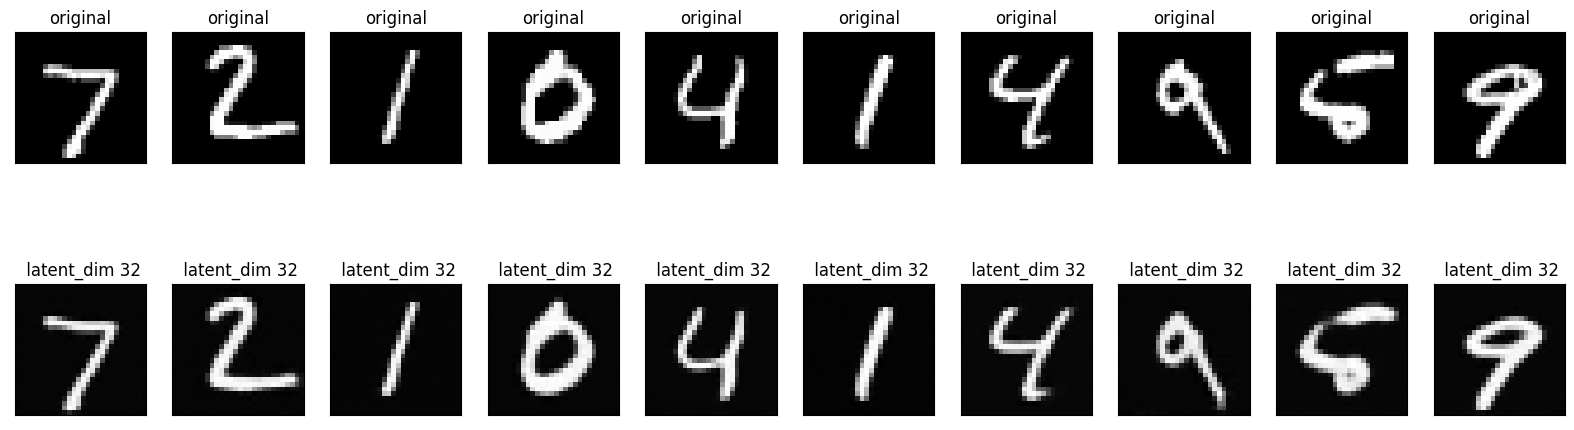

In [10]:
plot_images(data_decoded,x_test)

In [ ]:
for a in data_encoded:
    print(a.shape)


1
(<class '__main__.ConvolutionalAutoencoderv1'>, {'latent_dim': 32})


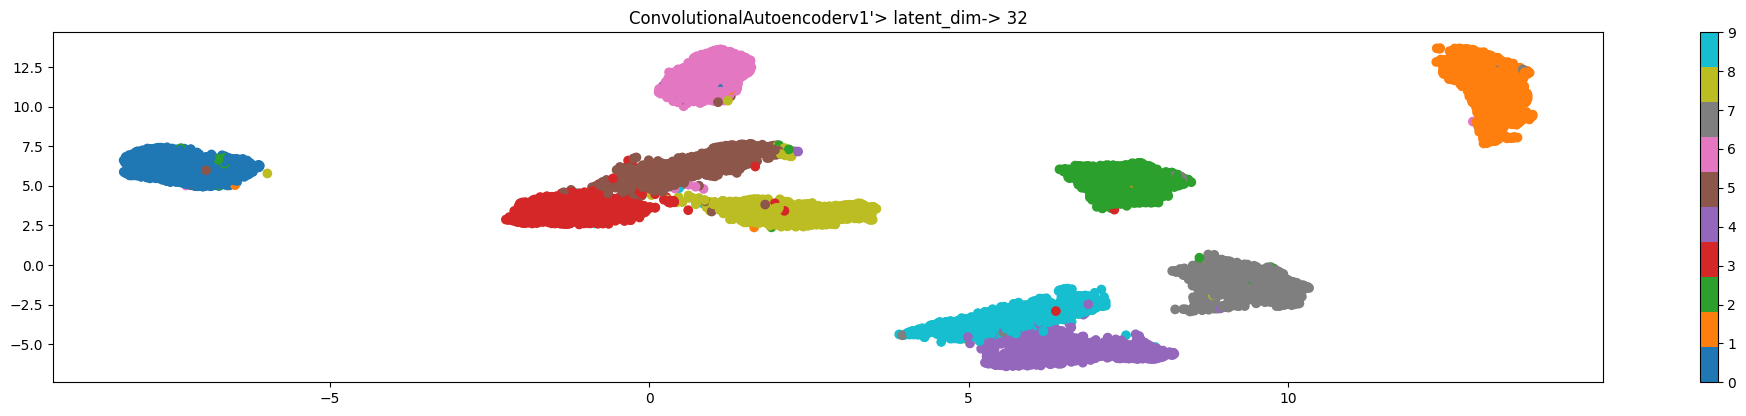

In [9]:
plot_umap(x_test,y_test)
